<a href="https://colab.research.google.com/github/vbwanere/SEDS_in_jax/blob/main/gmr_lib/GMR_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GMR**

Python jax implementation of Gaussian Mixture Regression Model

# 1\. Introduction:

We estimate a joint density of the inputs $x\  \epsilon \ \mathbb R^N$ and outputs $\dot x \ \epsilon \ \mathbb R^P$ through a K-component Gaussian mixture model as follows:

\begin{equation}
\tag{1}
p(x, \dot x|\Theta) = \sum_{k=1}^{K} \pi_k p(x, \dot x|\mu^k \Sigma^k)
\end{equation}

where,\
$\sum_{k=1}^{K} \pi_k = 1$ and $\mu^k = \begin{bmatrix}
\mu_{x}^{k}\\
\mu_{\dot x}^{k}
\end{bmatrix}$,
and $\ \Sigma^k =
\begin{bmatrix}
\Sigma_{xx}^{k} & \Sigma_{x\dot x}^{k} \\
\Sigma_{\dot xx}^{k} & \Sigma_{\dot x \dot x}^{k}
\end{bmatrix}$.

The conditional density is given by:
\begin{equation}
\tag{2}
p(\dot x|x) = \sum_{k=1}^{K} \gamma_k p(y|x;\mu^k \Sigma^k)
\end{equation}

where,
\begin{equation}
\tag{3}
\gamma_k = \frac{\pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}{\sum_{k=1}^{K} \pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}
\end{equation}

The regressive function $\dot x = f(x)$ is given by the expectation over this conditional density:
\begin{equation}
\tag{4}
\dot x = f(x) = \mathbf E[p(\dot x|x)] = \sum_{k=1}^{K} \gamma_k(x)\tilde \mu^k(x)
\end{equation}

where,
\begin{equation}
\tag{4}
\tilde \mu = \mu_{\dot x}^k + \Sigma_{\dot x x}^k(\Sigma_{x x}^k)^{-1}(x - \mu_x^k)
\end{equation}


## 1.1 Undestanding the dataset:

1. Inputs $x \ \epsilon \ \mathbb R^N$, for $M$ number of trajectories with each of length $T_m$ we have for $m^{th}$ trajectory:
\begin{equation}
X_m =
\begin{bmatrix}
x_1^1 & x_1^2 & ....... & x_1^{T_m}\\
& & &\\
x_N^1 & x_N^2 & ....... & x_N^{T_m}\\
\end{bmatrix}
\end{equation}

where, $m \ \epsilon \  \{1,....,M\}$, and $\{\mathbf X, \dot{\mathbf X}\} = \{X^m, \dot X^m\}_{m=1}^{M} = \{\{{x^{t,m}, {\dot x^{t,m}}\}_{t=1}^{T_m}}\}_{m=1}^{M}$.

# 2. `GMR` class:

In [147]:
import numpy as np
# import jax.numpy as jnp
# from jax import grad, jacfwd, jit, random, vmap
# from jax.scipy.stats import multivariate_normal
from sklearn import mixture
import scipy
import scipy.io
import pprint as pp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
import os

Please refer to the [this GMR library by Alexander Fabisch](https://github.com/AlexanderFabisch/gmr).

In [148]:
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses

## 2.1 Importing LASA Handwritten Dataset:
Please refer to [this python library](https://github.com/justagist/pyLasaDataset) for the [Handwritten Human Motion LASA Datset](https://www.epfl.ch/labs/lasa/datasets/).\
Please understand the dataset [here](https://bitbucket.org/khansari/lasahandwritingdataset/src/master/Readme.txt).

In [3]:
from pyLasaDataset import DataSet as lasa
from pyLasaDataset import utilities
plot_lasa = utilities.plot_model

Using LASA DataSet from c:\Users\vbwan\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLasaDataset/resources/LASAHandwritingDataset/DataSet


## 2.2 Visualizing Trajectories:

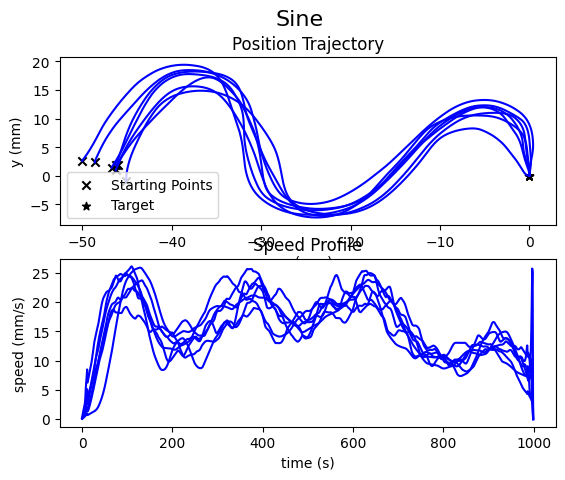

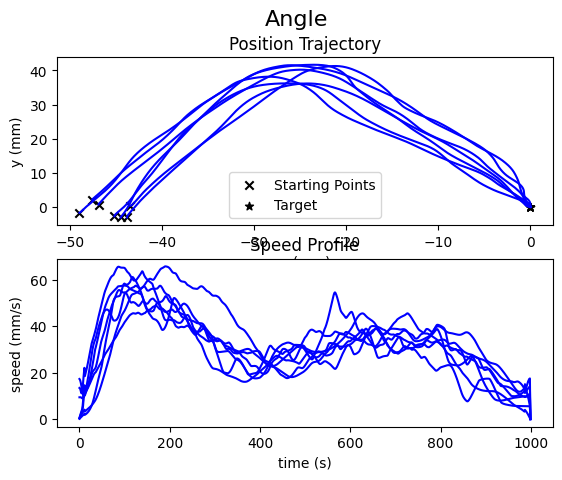

In [149]:
sine = lasa.Sine
angle = lasa.Angle
plot_lasa(sine)
plot_lasa(angle)

## 2.3 Fitting GMM on the `angle` data:

#### 2.3.1 Position and Velocity Datset

In [152]:
angle_demos = angle.demos
angle_1 = angle_demos[0]

# angle position
angle_pos = angle_1.pos.T # shape (1000, 2)

# angle velocity
angle_vel = angle_1.vel.T # shape (1000, 2)

for i in range(len(angle_demos)-1):
    concat_angle_pos = np.concatenate((angle_pos, (angle_demos[i+1].pos.T)), axis= 0 )
    angle_pos = concat_angle_pos
    
for i in range(len(angle_demos)-1):
    concat_angle_vel = np.concatenate((angle_vel, (angle_demos[i+1].vel.T)), axis= 0 )
    angle_vel = concat_angle_vel
    
# angle position and velocity: angle_dynamics:
angle_dynamics = np.concatenate((angle_pos, angle_vel), axis=1)

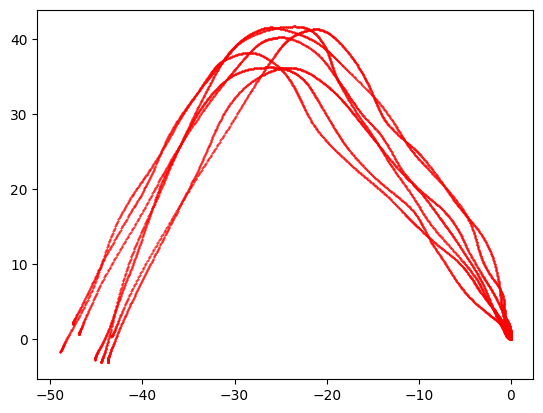

In [150]:
plt.scatter(angle_dynamics[:, 0], angle_dynamics[:, 1], c='r', marker = '.', s=0.8)

In [126]:
gmm = GMM(n_components=2, random_state=0)
gmm.from_samples(angle_dynamics)

#### 2.3.2 Predicting Velocities using GMR:

In [146]:
# Define the range and number of points for x and y
x_start, x_end = -50, 5
y_start, y_end = -5, 50
num_points = 50  # Number of points in each dimension

# Generate the grid dataset using np.linspace
x = np.linspace(x_start, x_end, num_points)
y = np.linspace(y_start, y_end, num_points)

# Create a meshgrid from the x and y values
x_grid, y_grid = np.meshgrid(x, y)

# Flatten the grids to create the dataset
x_dataset = x_grid.flatten()
y_dataset = y_grid.flatten()

# Combine x and y values to create the final 2D dataset
test_pos = np.column_stack((x_dataset, y_dataset))

In [142]:
# predicted velocity using gmr:
pred_vel = gmm.predict(np.array([2, 3]), test_pos)

# u component of velocity
pred_vel_u = pred_vel[:, 0].reshape(x_grid.shape)

# v component of velocity
pred_vel_v = pred_vel[:, 1].reshape(x_grid.shape)

#### 2.3.3 Plotting Predicted Velocities Streamlines:

In [144]:
# Function for plotting Guassian Ellipses:

def plot_gmm(mean, cov, color='k'):
    """Plot a single gaussian component"""
    # Get the eigenvalues and eigenvectors
    eigen_vals, eigen_vecs = np.linalg.eig(cov)

    # Get the index of the largest eigenvalue 
    idx = eigen_vals.argsort()[::-1] 
    eigen_vals, eigen_vecs = eigen_vals[idx], eigen_vecs[:,idx]

    theta = np.degrees(np.arctan2(*eigen_vecs[:,0][::-1]))

    # Ellipse properties 
    width, height = 2 * np.sqrt(eigen_vals)
    ellipse = patches.Ellipse(mean, width, height, angle=theta, facecolor='none', edgecolor=color)
    # ellipse.set_linestyle('--')
    ellipse.set_linewidth(4)
    return ellipse

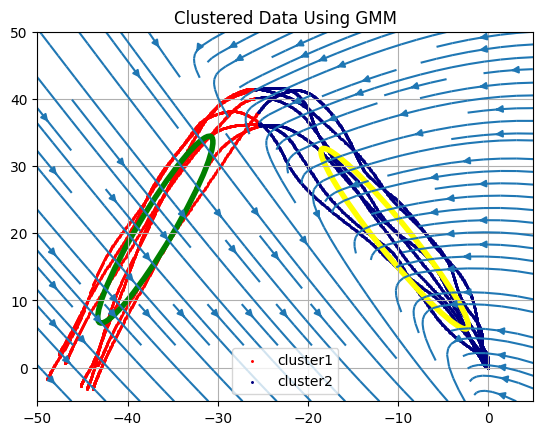

In [145]:
# color for each component:
color_iter_data = itertools.cycle(["red", "navy", "c", "cornflowerblue", "gold",\
    "darkorange", "green", "blue", "purple", "pink"])

# color for Gaussian ellipses:
color_iter_gmm = itertools.cycle(["green", "yellow", "black", "cornflowerblue", "gold"])


# plt.figure(figsize=(10, 10))
fig, ax = plt.subplots()
# plotting clustered datapoints for each component in loop:
for i in range(gmm_angle.k):
    ax.scatter(angle_dynamics[:, :2][pred_angle_pos == i, 0],\
        angle_dynamics[:, :2][pred_angle_pos == i, 1], s=5,\
        c=next(color_iter_data), marker='.', label='cluster' + str(i + 1))
    # ax.quiver(angle_dynamics[:, :2][pred_angle_pos == i, 0],\
        # angle_dynamics[:, :2][pred_angle_pos == i, 1],\
        # angle_dynamics[:, 2:][pred_angle_pos == i, 0],\
        # angle_dynamics[:, 2:][pred_angle_pos == i, 1])

# plotting Gaussian ellipses for each component in a loop:
for i in range(gmm_angle.k):
    ellipse = plot_gmm(gmm_angle.means[i], gmm_angle.covariances[i], color=next(color_iter_gmm))
    ax.add_patch(ellipse)

# plottin streamlines for predicted velocities:
ax.streamplot(x_grid, y_grid, pred_vel_u, pred_vel_v, density=1)

plt.title('Clustered Data Using GMM')
plt.legend(scatterpoints=1)
plt.grid()

plt.show()

# 3. Using SEDS Algorithm to fit the GMR on the dataset: